In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (28,28,1)
n_components= 2

### Test model with just UMAP

In [10]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [11]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [12]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [13]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [14]:
umap_graph.nnz

1030622

In [15]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [34]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [35]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [164]:
edges_to_exp = np.expand_dims(edges_to_exp, 1)
edges_from_exp = np.expand_dims(edges_from_exp, 1)

In [165]:
negative_sample_rate = 5

In [166]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [167]:
edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
edge_iter = edge_iter.shuffle(10000)
#edge_iter = edge_iter.map(gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)
edge_iter = edge_iter.batch(batch_size, drop_remainder=True)
edge_iter = edge_iter.prefetch(100)

In [168]:
a, b = next(iter(edge_iter))

### initialize embedding

In [237]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [247]:
embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

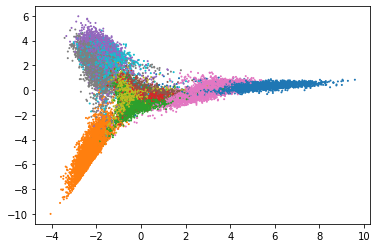

In [249]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

#### Build network

In [250]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    #@tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [251]:
from tensorflow.keras.layers import Input

In [252]:
"""encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])"""

'encoder = tf.keras.Sequential([\n    tf.keras.layers.InputLayer(input_shape=dims),\n    tf.keras.layers.Conv2D(\n        filters=64, kernel_size=3, strides=(2, 2), activation="relu"\n    ),\n    tf.keras.layers.Conv2D(\n        filters=128, kernel_size=3, strides=(2, 2), activation="relu"\n    ),\n\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(units=512, activation="relu"),\n    tf.keras.layers.Dense(units=512, activation="relu"),\n    tf.keras.layers.Dense(units=n_components),\n])'

In [253]:
n_data = len(X_train)

In [254]:
embed_layer = tf.keras.layers.Embedding(n_data, n_components, name="z", input_length = 1)
embed_layer.build(input_shape=(1,))
embed_layer.set_weights([embedding])

In [255]:
embed_layer

In [273]:
embedder = tf.keras.Sequential([embed_layer])

In [335]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64, input_length=1)
])
model.compile('rmsprop', 'mse')

#output_array = model.predict(np.random.randint(1000, size=(32)))
#print(output_array.shape)

model.fit(
    np.random.randint(1000, size=(10000)), 
    np.zeros(10000)
)

313/313 [==============================] - 1s 2ms/step - loss: 3.8260e-04


In [343]:
x = Input(shape=(1), name = "in")
embedder = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64, input_length=1)
])
out_x = embedder(x)[:,-1,:]

model = tf.keras.Model(
    inputs=[x],
    outputs=[out_x],
)

model.compile('rmsprop', 'mse')

model.fit(
    np.random.randint(1000, size=(10000)), 
    np.zeros(10000)
)

313/313 [==============================] - 1s 2ms/step - loss: 3.8538e-04


In [347]:
to_x = Input(shape=(1), name = "to_x")
from_x = Input(shape=(1), name = "from_x")

embedder = tf.keras.Sequential([
    tf.keras.layers.Embedding(50000, 2, input_length=1)
])

embedding_to = embedder(to_x)[:,-1,:]
embedding_from = embedder(from_x)[:,-1,:]


embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)


model = tf.keras.Model(
    inputs=[to_x],#, from_x],
    outputs=[embedding_to],#[embedding_to_from],
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss = 'mse'
    #loss={"umap":umap_loss(batch_size, negative_sample_rate, _a, _b)}
)

history = model.fit(
    np.random.randint(1000, size=(10000)), 
    np.zeros(10000)
)

313/313 [==============================] - 1s 2ms/step - loss: 2.8265e-04


In [ ]:
to_x = Input(shape=(1), name = "to_x")
from_x = Input(shape=(1), name = "from_x")

embedder = tf.keras.Sequential([
    tf.keras.layers.Embedding(50000, 2, input_length=1)
])

embedding_to = embedder(to_x)[:,-1,:]
embedding_from = embedder(from_x)[:,-1,:]


embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)


model = tf.keras.Model(
    inputs=[to_x],#, from_x],
    outputs=[embedding_to],#[embedding_to_from],
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss = 'mse'
    #loss={"umap":umap_loss(batch_size, negative_sample_rate, _a, _b)}
)

history = model.fit(
    np.random.randint(1000, size=(10000)), 
    np.zeros(10000)
)

In [345]:
model.inputs, model.outputs

([<tf.Tensor 'to_x_29:0' shape=(None, 1) dtype=float32>],
 [<tf.Tensor 'strided_slice_2:0' shape=(None, 2) dtype=float32>])

In [322]:
test = model.predict((a, b))

In [350]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b)
)

In [351]:
history = model.fit(
    edge_iter
)

7709/7709 [==============================] - 22s 3ms/step - loss: 2.2837


In [353]:
z = embedder(np.arange(len(X_train)))

In [354]:
z.shape

TensorShape([50000, 1, 2])

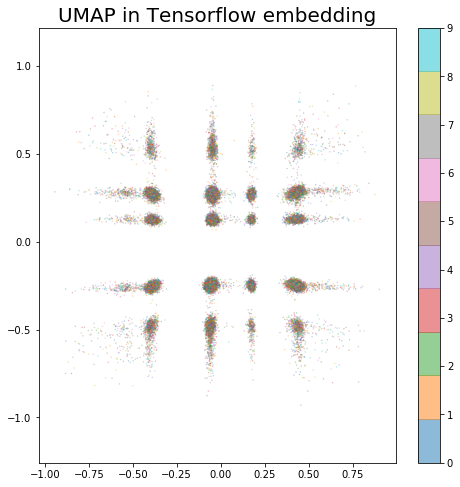

In [355]:
z = embedder(np.arange(len(X_train)))[:,-1,:]

fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [324]:
[i.name for i in model.layers]

['to_x', 'sequential_7', 'tf_op_layer_Sum_23']

#### train

ValueError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.trainable_variables)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2737 _minimize
        trainable_variables))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['embeddings:0'].


In [314]:
history = model.fit(
    edge_iter,
    #epochs=5,
    #max_queue_size = 100,
    #use_multiprocessing=True, 
    #workers = -1,
)

AssertionError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("umap/umap_24/Identity:0", shape=(None, 4), dtype=float32)


In [282]:
np.zeros(len(edges_to_exp)).shape

(7709284,)

In [284]:
edges_to_exp.shape

(7709284, 1)

In [283]:
history = model.fit(
    x=(edges_to_exp, edges_from_exp),
    y=np.zeros((len(edges_to_exp),1)),
    #epochs=5,
    #max_queue_size = 100,
    #use_multiprocessing=True, 
    #workers = -1,
)

TypeError: 'NoneType' object is not callable

In [271]:
z = embed_layer(np.arange(len(X_train)))

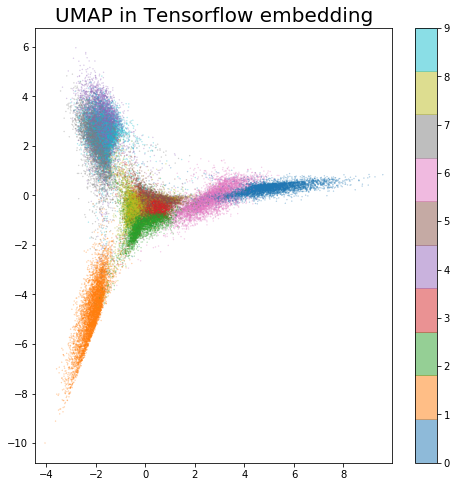

In [272]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [35]:
plt.plot(history.history['loss'])

NameError: name 'history' is not defined

In [296]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 64, input_length=1))
# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(1000, size=(32))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)

model.fit(
    np.random.randint(1000, size=(10000)), 
    np.zeros(10000)
)

W0812 14:27:40.372965 140166606243648 def_function.py:120] 8 out of the last 39 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f78ec7201e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(32, 1, 64)


313/313 [==============================] - 0s 2ms/step - loss: 3.8175e-04
